# Imports 

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

from pmesh.pm import ParticleMesh
from nbodykit.lab import BigFileCatalog, BigFileMesh, FFTPower, MultipleSpeciesCatalog
from matplotlib.colors import LogNorm
from scipy.integrate import simps


sys.path.append('../code/utils/')
sys.path.append('../code/')
import tools, dohod, hod
import hodanalytics as hodanals
from time import time
import mymass_function as massfunc

Populating the interactive namespace from numpy and matplotlib


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): omegab, omegam
  self.engine = ClassEngine(pars)


In [3]:
cosmodef = {'omegam':0.309167, 'h':0.677, 'omegab':0.048}
omM =  cosmodef['omegam']
mf = massfunc.Mass_Func('../data/pk_Planck2018BAO_matterpower_z000.dat', M=omM)


In [4]:
from nbodykit.cosmology.cosmology import Cosmology
cosmodef = {'omegam':0.309167, 'h':0.677, 'omegab':0.048}
cosmo = Cosmology.from_dict(cosmodef)
dpath = '/project/projectdirs/m3127/H1mass/'
yscratch = '/global/cscratch1/sd/yfeng1/m3127/'
myscratch = '/global/cscratch1/sd/chmodi/m3127/'

aafiles = np.array([0.1429, 0.1538, 0.1667, 0.1818, 0.2000, 0.2222, 0.2500, 0.2857, 0.3333])
zzfiles = np.array([round(tools.atoz(aa), 2) for aa in aafiles])

h = 0.6776
bs = 256



# Moster & Dave


[]

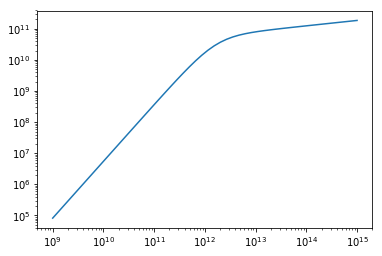

In [9]:


def moster(Mhalo,z,h=0.6776, scatter=None):
    """                                                                                                                                                                                                                                                                                   
    moster(Minf,z):                                                                                                                                                                                                                                                                       
    Returns the stellar mass (M*/h) given Minf and z from Table 1 and                                                                                                                                                                                                                       
    Eq. (2,11-14) of Moster++13 [1205.5807].                                                                                                                                                                                                                                              
    This version now works in terms of Msun/h units,
    convert to Msun units in the function
    To get "true" stellar mass, add 0.15 dex of lognormal scatter.                                                                                                                                                                                                                        
    To get "observed" stellar mass, add between 0.1-0.45 dex extra scatter.                                                                                                                                                                                                               
    """
    Minf = Mhalo/h
    zzp1  = z/(1+z)
    M1    = 10.0**(11.590+1.195*zzp1)
    mM    = 0.0351 - 0.0247*zzp1
    beta  = 1.376  - 0.826*zzp1
    gamma = 0.608  + 0.329*zzp1
    Mstar = 2*mM/( (Minf/M1)**(-beta) + (Minf/M1)**gamma )
    Mstar*= Minf
    if scatter is not None: 
        Mstar = 10**(np.log10(Mstar) + np.random.normal(0, scatter, Mstar.size))
    return Mstar*h
    #                                                                                                                                                                                                                                                                                     

    
def dave(mhalo, zz, h=0.6776, scatter=None):
    mcut = mcutf(zz)
    mstar = moster(mhalo, zz, h=h, scatter=scatter)/h
    m, c = np.polyfit([8.1, 11], [0.2, -1], deg=1)
    xx = np.log10(mstar)
    yy = m* xx + c
    mh1 = mstar * 10**yy
    return mh1*h * np.exp(-mcut/mhalo)

    
mh = np.logspace(9, 15)
plt.plot(mh, moster(mh, 2))
plt.loglog()

In [36]:
# mh = np.logspace(10, 15)
# plt.plot((mh/h), (moster(mh, 0)/0.164/mh), 'C0-', lw=2, label='z=0, Stellar')
# plt.plot((mh/h), (dave(mh, 0)/0.164/mh), 'C0--', lw=2, label='z=0, HI')
# plt.plot((mh/h), (moster(mh, 2)/0.164/mh), 'C2-', lw=2, label='z=2')
# plt.plot((mh/h), (dave(mh,2)/0.164/mh), 'C2--', lw=2)
# plt.plot((mh/h), (moster(mh, 4)/0.164/mh), 'C6-', lw=2, label='z=4')
# plt.plot((mh/h), (dave(mh,4)/0.164/mh), 'C6--', lw=2)
# plt.ylim(0.0001, 1)
# plt.loglog()
# plt.grid(which='both')
# plt.legend( fontsize=14)
# plt.xlabel('M$_h$/h', fontsize=14)
# plt.ylabel('M / (f$_b$ M$_h$)', fontsize=14)


# your files


In [75]:
dpath = '/global/cscratch1/sd/chmodi/m3127/H1mass/highres/2560-9100-fixed/'


hmassd = {}
for iz, zz in enumerate(zzfiles):
    aa = aafiles[iz]
    ccat = BigFileCatalog(dpath + '/fastpm_%0.4f/cencat-m1_00p3mh-alpha-0p8-subvol/'%aa)
    hmassd[zz] = ccat['HaloMass'].compute()
    


In [76]:
hmasscdfd = {}
for iz, zz in enumerate(zzfiles):
    hmasscdfd[zz] = mf.icdf_sampling(bs, mfunc='ST', hmass=hmassd[zz], zz=zz, lmmin=9, lmmax=15)


In [77]:
mbinsh = np.arange(9, 14, 0.2)


def nwhist(ar, lbins):
    n = np.histogram(np.log10(ar), lbins)[0]
    w = np.histogram(ar, 10**lbins, weights=ar)[0]
    return n, w/n

nhhmfd, mhhmfd = {}, {}
for iz, zz in enumerate(zzfiles):
    n, m = nwhist(hmassd[zz], mbinsh)
    nhhmfd[zz] = n
    mhhmfd[zz] = m

fachmfbin = diff(log(10**mbinsh))[0]*bs**3


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


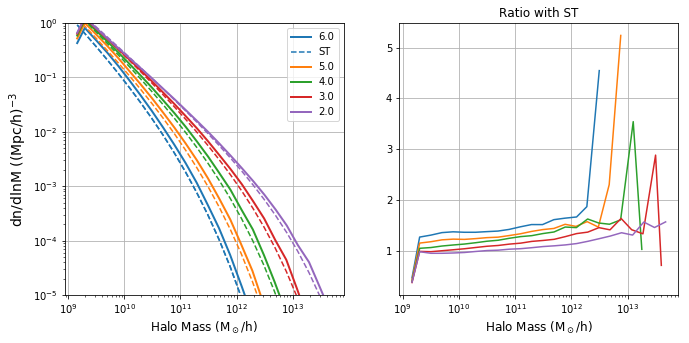

In [78]:
plt.figure(figsize = (11, 5))

ax = plt.subplot(1, 2, 1)
for iz , zz in enumerate(zzfiles[::2]):
#     plt.plot(mhhmf[zz], nhhmf[zz]/bs**3/0.2, 'C%d:'%iz, lw=2, label=zz)
    plt.plot(mhhmfd[zz], nhhmfd[zz]/fachmfbin, 'C%d'%iz, lw=2, label=zz)
    plt.plot(mhhmfd[zz], mf.STf(mhhmfd[zz], 1/(zz+1)), 'C%d--'%iz)
    if not iz: plt.plot(mhhmfd[zz], mf.STf(mhhmfd[zz], 1/(zz+1)), 'C%d--'%iz, label='ST')
    
plt.loglog()
plt.ylim(1e-5, 1)
plt.grid()
plt.legend()


ax = plt.subplot(1, 2, 2)
for iz , zz in enumerate(zzfiles[::2]):
    plt.plot(mhhmfd[zz], nhhmfd[zz]/fachmfbin/mf.STf(mhhmfd[zz], 1/(zz+1)), 'C%d'%iz)
#     plt.plot(mhhmf[zz], , 'C%d--'%iz)
    
plt.semilogx()
# plt.ylim(1e-5, 1)
plt.grid()
plt.title('Ratio with ST')

ax = gcf().axes
for axis in ax:
    axis.set_xlabel('Halo Mass (M$_\odot$/h)', fontsize=12)
    ax[0].set_ylabel('dn/dlnM ((Mpc/h)$^{-3}$', fontsize=14)
    

# SMF

In [41]:
stellarmassd = {}

for iz, zz in enumerate(zzfiles):
    stellarmassd[zz] = moster(hmassd[zz], zz)/h


In [42]:
mbinss = np.arange(8, 12, 0.2)


def nwhist(ar, lbins):
    n = np.histogram(np.log10(ar), lbins)[0]
    w = np.histogram(ar, 10**lbins, weights=ar)[0]
    return n, w/n

nssmfd, mssmfd = {}, {}
for iz, zz in enumerate(zzfiles):
    n, m = nwhist(stellarmassd[zz], mbinss)
    nssmfd[zz] = n
    mssmfd[zz] = m

facsmfbin = diff(log10(10**mbinss))[0]*(bs/h)**3


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [43]:
 diff(log10(10**mbinss))[0]*(bs/h)**3,  diff((mbinss))[0]*(bs/h)**3

(10785237.166181993, 10785237.166181993)

In [44]:
smfpath = '/global/u1/c/chmodi/Programs/21cm/21cmhod/data/behroozi-2013-data-compilation/smf_ms/'

stellarmassdatad = {}
stellarmassdatad[2.0] = np.loadtxt(smfpath + '/mortlock_z%0.1f.smf'%2.0).T
stellarmassdatad[2.5] = np.loadtxt(smfpath + '/mortlock_z%0.1f.smf'%2.5).T
stellarmassdatad[4.0] = np.loadtxt(smfpath + '/kslee_z%d.smf'%4.0).T
stellarmassdatad[3.5] = np.loadtxt(smfpath + '/marchesini_z3.5.smf').T
stellarmassdatad[5.0] = np.loadtxt(smfpath + '/kslee_z%d.smf'%5).T
stellarmassdatad[6.0] = np.loadtxt(smfpath + '/stark_z%d.smf'%6).T


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


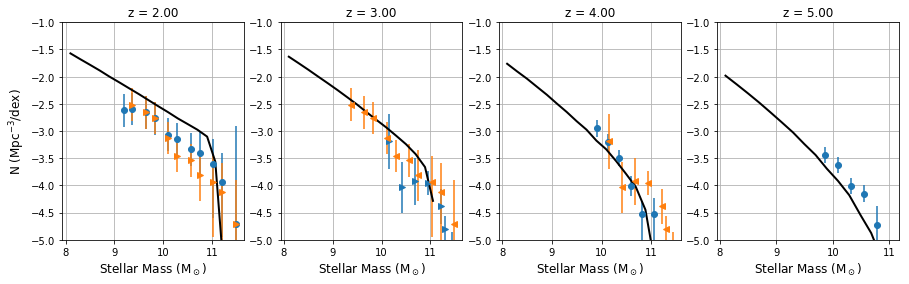

In [45]:
plt.figure(figsize = (15, 4))
zplot = [2.0, 3.0, 4.0, 5.0]
for iz , zz in enumerate(zplot):
    ax = plt.subplot(1, len(zplot), iz+1)
    plt.plot(log10(mssmfd[zz]), log10(nssmfd[zz]/facsmfbin), 'k', lw=2, label=zz)
    
    try:
        data = stellarmassdatad[zz]
        plt.errorbar(data[0], data[1], [data[3], data[2]], fmt='o')
    except: pass
    try:
        data = stellarmassdatad[zz+0.5]
        plt.errorbar(data[0], data[1], [data[3], data[2]], fmt='>')
    except: pass
    try:
        data = stellarmassdatad[zz-0.5]
        plt.errorbar(data[0], data[1], [data[3], data[2]], fmt='<')
    except: pass

    plt.title('z = %0.2f'%zz)
#     plt.loglog()
#     plt.plot(mssmfd[zz], mf.STf(mhhmfd[zz], 1/(zz+1)), 'C%d--'%iz)
ax = gcf().axes
for axis in ax:
    axis.set_xlabel('Stellar Mass (M$_\odot$)', fontsize=12)
    ax[0].set_ylabel('N (Mpc$^{-3}$/dex)', fontsize=12)
    axis.set_ylim(-5, -1)
    axis.grid()
    
#     ax[0].set_ylabel('dn/dlogM ((Mpc)$^{-3}$', fontsize=14)


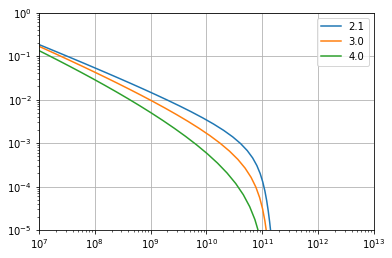

In [46]:
for iz, zz in enumerate([2.1, 3.0, 4.0]):
    aa = 1/(zz+1)
    num = mf.STf(mh, aa) * (h)**3 * np.log(10)
    mstar = moster(mh, zz)/h
    plt.plot(mstar, num, label=zz)
plt.loglog()
plt.ylim(10**-5, 1)
plt.xlim(1e7, 1e13)
plt.legend()
plt.grid()

# OmHI

Text(0, 0.5, '$\\Omega\\ \\rm{HI}\\ x\\ 10^3$')

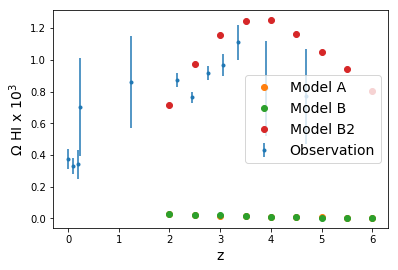

In [17]:
def rhoCritCom(zz, omm=0.309167, omx=0.690833, hub=0.677):
    """Returns the critical density (in Msun/h and Mpc/h units) at                                                                      
       redshift zz, scaled by comoving volume."""
    rho = 2.7754e11*( omm*(1+zz)**3+omx )/(1+zz)**3
    return(rho)


omh1data = np.loadtxt('../data/omega_HI_obs.txt').T
plt.errorbar(omh1data[0], omh1data[1], omh1data[2], fmt='.', label='Observation')


def disttoomh1(mod, bs, physical=False):
    omh1 = []
    fname = '../data/outputs/m1_00p3mh-alpha-0p8-subvol/'
    if bs == 1024:
        fname = fname[:-1] + '-big/'
    fname = fname + '/Model%s/'%(mod)        
    for aa in aafiles:
        dist = np.loadtxt(fname + 'HI_dist_%0.4f.txt'%aa).T
        h1 = (dist[1]*dist[2]).sum()
        h1 /= bs**3 
        if physical: h1 /= aa**3
        h1 /= rhoCritCom(0)
        omh1.append(h1)
    return np.array(omh1)    

omh1 = disttoomh1('A', 256)
plt.plot(zzfiles, omh1*1e3, 'o', label='Model A')

omh1 = disttoomh1('B', 256)
plt.plot(zzfiles, omh1*1e3, 'o', label='Model B')
omh1 = disttoomh1('B', 256, physical=True)
plt.plot(zzfiles, omh1*1e3, 'o', label='Model B2')

plt.legend(fontsize=14)
plt.xlabel('z', fontsize=14)
plt.ylabel(r'$\Omega\ \rm{HI}\ x\ 10^3$', fontsize=14)

# omh1 = disttoomh1('A', 1024)
# plt.plot(zzfiles, omh1*1e3, 'k*', alpha=0.5)


## Analytic HI occupancy Model A

[]

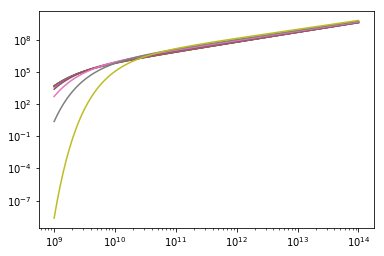

In [10]:
betaf = lambda zz: (1+2*zz)/(2+2*zz)
mcutfold = lambda zz : 1e9*( 1.8 + 15*(3/(zz+1))**8 )
mcutf = lambda zz: 3e9*( 1 + 10*(3/(zz+1))**8)
normf = lambda zz : 3e5*(1+(3.5/zz)**6)

mh = np.logspace(9, 14, 100)
mhh1Ad = {} 
for iz, zz in enumerate(zzfiles):
    mcut, alpha, A = mcutf(zz), betaf(zz), normf(zz)
    mhh1Ad[zz] = hodanals.HIm(mh, mcut, alpha, A)

for iz, zz in enumerate(zzfiles):
    plt.plot(mh, mhh1Ad[zz])
plt.loglog()

In [49]:
# count the total number of halos as a test, before matching mass function

for iz, zz in enumerate(zzfiles):
    aa = 1/(zz+1)
    mmin = hmassd[zz][-1]
    lnmh = np.log(np.logspace(np.log10(mmin), 15, 1000))
    num = mf.STf(np.exp(lnmh), aa) * bs**3
    n = simps(num, lnmh)
    print(zz, hmassd[zz].size/n)



6.0 1.3370252556869027
5.5 1.2716709936049477
5.0 1.2079121054382806
4.5 1.1468757812870094
4.0 1.1007334873073067
3.5 1.0591413607631806
3.0 1.0263283178603
2.5 1.0089252644978095
2.0 0.9974167729734232


In [50]:
# count the total number of halos as a test, after matching mass function
for iz, zz in enumerate(zzfiles):
    aa = 1/(zz+1)
    mmin = hmasscdfd[zz][-1]
    lnmh = np.log(np.logspace(np.log10(mmin), 15, 10000))
    num = mf.STf(np.exp(lnmh), aa) * bs**3
    n = simps(num, lnmh)
    print(zz, hmasscdfd[zz].size/n)

    


6.0 1.0098520482502291
5.5 1.0101798778239683
5.0 1.0101123160996912
4.5 1.0100707610118291
4.0 1.0101739183058747
3.5 1.0102045891402587
3.0 1.010330413583553
2.5 1.0105089094934312
2.0 1.0104996535148136


Text(0, 0.5, '$\\Omega\\ \\rm{HI}\\ x\\ 10^3$')

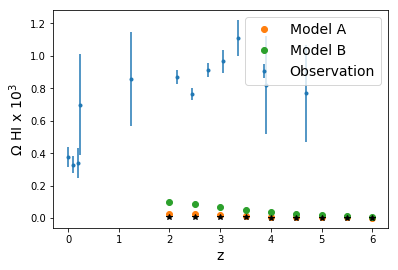

In [51]:
#Get total HI

h1tot = np.zeros_like(zzfiles)
for iz, zz in enumerate(zzfiles):
    aa = 1/(zz+1)
    mmin = hmasscdfd[zz][-1]
    lnmh = np.log(np.logspace(np.log10(mmin), 15, 10000))
    num = mf.STf(np.exp(lnmh), aa) * bs**3

    mcut, alpha, A = mcutf(zz), betaf(zz), normf(zz)
    mh1 = hodanals.HIm(np.exp(lnmh), mcut, alpha, A)
    n = simps(num*mh1, lnmh)
    h1tot[iz] = n/bs**3
    
plt.errorbar(omh1data[0], omh1data[1], omh1data[2], fmt='.', label='Observation')

omh1 = disttoomh1('A', 256)
plt.plot(zzfiles, omh1*1e3, 'o', label='Model A')

omh1 = disttoomh1('B', 256)
plt.plot(zzfiles, omh1*1e3, 'o', label='Model B')

plt.plot(zzfiles, h1tot/rhoCritCom(0)*1e3, 'k*')

plt.legend(fontsize=14)
plt.xlabel('z', fontsize=14)
plt.ylabel(r'$\Omega\ \rm{HI}\ x\ 10^3$', fontsize=14)


## get HI right for model A

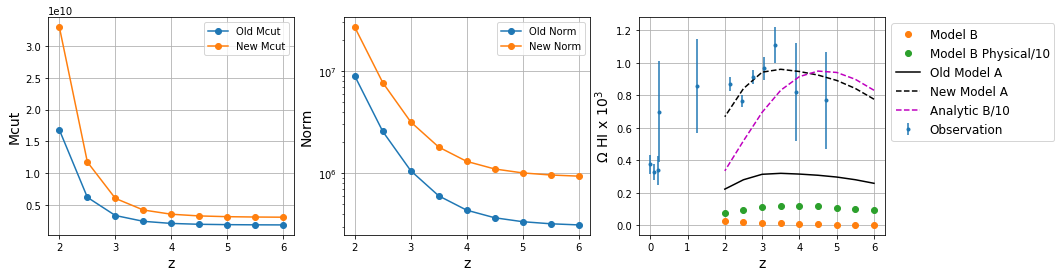

In [79]:
# normfplay = lambda zz : 3e7 *(4+(3.5/zz)**6) #without (1+z)**3
# normfplay = lambda zz : 1e6 *(4+(3.5/zz)**6)
normfplay = lambda zz : normf(zz)*3
normfone = lambda zz : 2e8 +zz*0



#Get total HI
plt.figure(figsize = (15, 4))


ax = plt.subplot(1, 3, 1)
plt.plot(zzfiles, mcutfold(zzfiles), marker='o', label='Old Mcut')
plt.plot(zzfiles, mcutf(zzfiles), marker='o', label='New Mcut')
# plt.plot(zzfiles, normfone(zzfiles), marker='s')
plt.legend()
plt.grid()
plt.xlabel('z', fontsize=14)
plt.ylabel('Mcut', fontsize=14)

############

ax = plt.subplot(1, 3, 2)

xz = np.linspace(2, 6)
plt.plot(zzfiles, normf(zzfiles), marker='o', label='Old Norm')
plt.plot(zzfiles, normfplay(zzfiles), marker='o', label='New Norm')
# plt.plot(zzfiles, normfone(zzfiles), marker='s')
plt.semilogy()
plt.legend()
plt.grid()
plt.xlabel('z', fontsize=14)
plt.ylabel('Norm', fontsize=14)


#####
ax = plt.subplot(1, 3, 3)
plt.errorbar(omh1data[0], omh1data[1], omh1data[2], fmt='.', label='Observation')

omh1 = disttoomh1('A', 256)
# plt.plot(zzfiles, omh1*1e3, 'o', label='Model A')
# omh1 = disttoomh1('A', 256, physical=True)
# plt.plot(zzfiles, omh1*1e3, 'o', label='Model A Physical')

omh1 = disttoomh1('B', 256)
plt.plot(zzfiles, omh1*1e3, 'o', label='Model B')
omh1 = disttoomh1('B', 256, physical=True)
plt.plot(zzfiles, omh1*1e3/10, 'o', label='Model B Physical/10')

# plt.plot(zzfiles, h1tot/rhoCritCom(0)*1e3, 'k*')

h1tot = np.zeros_like(zzfiles) 
h1totplay = np.zeros_like(zzfiles)
h1totone = np.zeros_like(zzfiles)
h1dave = np.zeros_like(zzfiles)
for iz, zz in enumerate(zzfiles):
    aa = 1/(zz+1)
    mmin = hmasscdfd[zz][-1]
    lnmh = np.log(np.logspace(np.log10(mmin), 15, 10000))
    num = mf.STf(np.exp(lnmh), aa) * bs**3
    
    mcut, alpha, A = mcutf(zz), betaf(zz), normf(zz)
    mh1 = hodanals.HIm(np.exp(lnmh), mcut, alpha, A)
    n = simps(num*mh1, lnmh)
    h1tot[iz] = n/bs**3 *(1+zz)**3

    mcut, alpha, A = mcutf(zz), betaf(zz), normfplay(zz)
    mh1 = hodanals.HIm(np.exp(lnmh), mcut, alpha, A)
    n = simps(num*mh1, lnmh)
    h1totplay[iz] = n/bs**3 *(1+zz)**3
    
    mcut, alpha, A = mcutf(zz), betaf(zz), normfone(zz)
    mh1 = hodanals.HIm(np.exp(lnmh), mcut, alpha, A)
    n = simps(num*mh1, lnmh)
    h1totone[iz] = n/bs**3 *(1+zz)**3
    
    mh1 = dave(np.exp(lnmh), zz)
    n = simps(num*mh1, lnmh)
    h1dave[iz] = n/bs**3 *(1+zz)**3
    
    
    
plt.plot(zzfiles, h1tot/rhoCritCom(0)*1e3, 'k',label='Old Model A')
plt.plot(zzfiles, h1totplay/rhoCritCom(0)*1e3, 'k--',label='New Model A')
plt.plot(zzfiles, h1dave/rhoCritCom(0)*1e3/10., 'm--',label='Analytic B/10')
# plt.plot(zzfiles, h1totone/rhoCritCom(0)*1e3, 'm')

plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('z', fontsize=14)
plt.ylabel(r'$\Omega\ \rm{HI}\ x\ 10^3$', fontsize=14)
# plt.yscale('log')
plt.grid()
plt.show()



## get HI right for model B

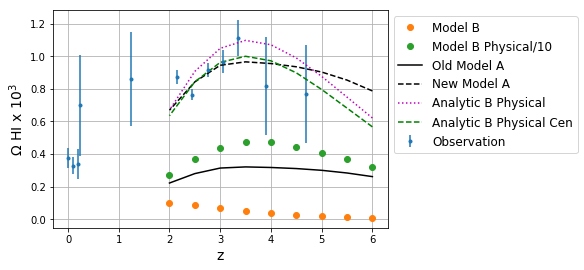

In [57]:

f = 0.03
alphasat = -0.8


def moster(Mhalo,z,h=0.6776, scatter=None):
    """                                                                                                                                                                                                                                                                                   
    moster(Minf,z):                                                                                                                                                                                                                                                                       
    Returns the stellar mass (M*/h) given Minf and z from Table 1 and                                                                                                                                                                                                                       
    Eq. (2,11-14) of Moster++13 [1205.5807].                                                                                                                                                                                                                                              
    This version now works in terms of Msun/h units,
    convert to Msun units in the function
    To get "true" stellar mass, add 0.15 dex of lognormal scatter.                                                                                                                                                                                                                        
    To get "observed" stellar mass, add between 0.1-0.45 dex extra scatter.                                                                                                                                                                                                               
    """
    Minf = Mhalo/h
    zzp1  = z/(1+z)
    M1    = 10.0**(11.590+1.195*zzp1)
    mM    = 0.0351 - 0.0247*zzp1
    beta  = 1.376  - 0.826*zzp1
    gamma = 0.608  + 0.329*zzp1
    Mstar = 2*mM/( (Minf/M1)**(-beta) + (Minf/M1)**gamma )
    Mstar*= Minf
    if scatter is not None: 
        Mstar = 10**(np.log10(Mstar) + np.random.normal(0, scatter, Mstar.size))
    return Mstar*h
    #                                                                                                                                                                                                                                                                                     

    
def dave(mhalo, zz, h=0.6776, scatter=None):
    mcut = mcutf(zz)
    mstar = moster(mhalo, zz, h=h, scatter=scatter)/h
    m, c = np.polyfit([8.1, 11], [0.1, -1], deg=1)
    xx = np.log10(mstar)
    yy = m* xx + c
    mh1 = mstar * 10**yy
    return mh1*h * np.exp(-mcut/mhalo)

   
# def davequad(mhalo, zz, h=0.6776, scatter=None):
#     mcut = mcutf(zz)
#     mstar = moster(mhalo, zz, h=h, scatter=scatter)/h
#     xx = np.log10(mstar)
#     mm = 1e9
#     aa = 0.0
#     bb = 0.5
#     yy = log10(((10**xx/mm)**aa +(10**xx/mm)**bb)**-1) 
#     mh1 = mstar * 10**yy
#     return mh1*h * np.exp(-mcut/mhalo)


def davequad(mhalo, zz, h=0.6776, scatter=None):
    mcut = mcutf(zz)
    mstar = moster(mhalo, zz, h=h, scatter=scatter)/h

    mm = 1e9
    f = 0.2
    alpha = 0.5
    mfrac = f*(mm/(mstar + mm2))**alpha
    mh1 = mstar * mfrac
    return mh1*h * np.exp(-mcut/mhalo)


# #Get total HI
h1tot = np.zeros_like(zzfiles) 
h1totplay = np.zeros_like(zzfiles)
h1dave = np.zeros_like(zzfiles)
h1davequad = np.zeros_like(zzfiles)
h1davecen = np.zeros_like(zzfiles)

for iz, zz in enumerate(zzfiles):
    aa = 1/(zz+1)
    mmin = hmasscdfd[zz][-1]/10.
    lnmh = np.log(np.logspace(np.log10(mmin), 15, 10000))
    num = mf.STf(np.exp(lnmh), aa) * bs**3
    
    mcut, alpha, A = mcutf(zz), betaf(zz), normf(zz)
    mh1 = hodanals.HIm(np.exp(lnmh), mcut, alpha, A)
    n = simps(num*mh1, lnmh)
    h1tot[iz] = n/bs**3 *(1+zz)**3

    mcut, alpha, A = mcutf(zz), betaf(zz), normfplay(zz)
    mh1 = hodanals.HIm(np.exp(lnmh), mcut, alpha, A)
    n = simps(num*mh1, lnmh)
    h1totplay[iz] = n/bs**3 *(1+zz)**3
    
    mh1 = dave(np.exp(lnmh), zz)
    n = simps(num*mh1, lnmh)
    h1dave[iz] = n/bs**3 *(1+zz)**3

    mh1 = davequad(np.exp(lnmh), zz, scatter=None)
    n = simps(num*mh1, lnmh)
    h1davequad[iz] = n/bs**3 *(1+zz)**3

    numf = lambda m, mh: hodanals.nmsat(m, mh, f, alphasat)
    massf = lambda m: m
    msat = hodanals.massweightedsum(np.exp(lnmh), mcut/10., numf, massf)
    mh1 = davequad(np.exp(lnmh)-msat, zz)
    n = simps(num*mh1, lnmh)
    h1davecen[iz] = n/bs**3 *(1+zz)**3

    

plt.figure(figsize = (6, 4))

# ax = plt.subplot(1, 3, 3)
plt.errorbar(omh1data[0], omh1data[1], omh1data[2], fmt='.', label='Observation')

omh1 = disttoomh1('B', 256)
plt.plot(zzfiles, omh1*1e3, 'o', label='Model B')
omh1 = disttoomh1('B', 256, physical=True)
plt.plot(zzfiles, omh1*1e3/10, 'o', label='Model B Physical/10')
    
plt.plot(zzfiles, h1tot/rhoCritCom(0)*1e3, 'k',label='Old Model A')
plt.plot(zzfiles, h1totplay/rhoCritCom(0)*1e3, 'k--',label='New Model A')
# plt.plot(zzfiles, h1dave/rhoCritCom(0)*1e3, 'm--',label='Analytic B Physical')
plt.plot(zzfiles, h1davequad/rhoCritCom(0)*1e3, 'm:',label='Analytic B Physical')
plt.plot(zzfiles, h1davecen/rhoCritCom(0)*1e3, 'g--',label='Analytic B Physical Cen')

plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('z', fontsize=14)
plt.ylabel(r'$\Omega\ \rm{HI}\ x\ 10^3$', fontsize=14)
# plt.yscale('log')
plt.grid()
plt.show()



In [55]:
for iz, zz in enumerate(zzfiles):
    aa = 1/(zz+1)
    mmin = hmasscdfd[zz][-1]
    lnmh = np.log(np.logspace(np.log10(mmin), 15, 10000))
    num = mf.STf(np.exp(lnmh), aa) * bs**3
    nm = simps(num*np.exp(lnmh), lnmh)
    n = simps(num, lnmh)
    print(nm/ hmasscdfd[zz].sum(), n/ hmasscdfd[zz].size)



0.9887722386238759 0.9902440676658528
0.9881341672465038 0.9899227077796314
0.9882438928029591 0.9899889191147204
0.9883539225692659 0.9900296480201636
0.9880896436894978 0.9899285478257676
0.988189918538662 0.9898984925925318
0.9877914230478474 0.9897752126980799
0.9872519992870288 0.9896003791805267
0.9871052032599984 0.9896094437258908


In [ ]:
# plt.errorbar(omh1data[0], omh1data[1], omh1data[2], fmt='.', label='Observation')

# plt.plot(zzfiles, h1tot/rhoCritCom(0)*1e3, 'k',label='Old Model A')
# plt.plot(zzfiles, h1totplay/rhoCritCom(0)*1e3, 'k--',label='New Model A')
# # plt.plot(zzfiles, h1dave/rhoCritCom(0)*1e3, 'm--',label='Analytic B Physical')
# plt.plot(zzfiles, h1davequad/rhoCritCom(0)*1e3, 'm:',label='Analytic B Physical')
# plt.plot(zzfiles, h1davecen/rhoCritCom(0)*1e3, 'g--',label='Analytic B Physical Cen')
# # plt.plot(zzfiles, h1totone/rhoCritCom(0)*1e3, 'm')

# plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1,1))
# plt.xlabel('z', fontsize=14)
# plt.ylabel(r'$\Omega\ \rm{HI}\ x\ 10^3$', fontsize=14)
# # plt.yscale('log')
# plt.grid()
# plt.show()



In [ ]:
xx = np.linspace(7, 12)

a, b, c = np.polyfit([8.1, 9, 11], [0.1, 0, -1], deg=2)
m, im = np.polyfit([8.1, 11], [0.1,  -1], deg=1)
# plt.plot(xx, a*xx**2+b*xx+c)
plt.plot(xx, m*xx+im, label='linear fit')

mm = 1e9
aa = 0.1
bb = 0.5
# plt.plot(xx, log10(((10**xx/mm)**aa +(10**xx/mm)**bb)**-1) )
mm = 1e9
aa = 0.0
bb = 0.5
plt.plot(xx, log10(((10**xx/mm)**aa +(10**xx/mm)**bb)**-1) ,'--', label='broken power law', lw=2)
plt.grid()
plt.legend()
plt.xlabel('Stellar Mass (M$_\odot$)', fontsize=12)
plt.ylabel('log (M$_{HI}$/M$_{*}$)', fontsize=12)


In [ ]:
zz= 2
mcut, alpha, A = mcutf(zz), betaf(zz), normfplay(zz)
plt.plot(mh, hodanals.HIm(mh, mcut, alpha, A))
plt.plot(mh, davequad(mh, zz))
plt.loglog()

In [ ]:
zz = 3.0
mh1 = davequad(hmassd[zz], zz)
mh1cdf = davequad(hmasscdfd[zz], zz)

In [ ]:
mh1.sum()/bs**3*(1+zz)**3 / rhoCritCom(0)*1e3

In [ ]:
mh1cdf.sum()/bs**3*(1+zz)**3 / rhoCritCom(0)*1e3

In [ ]:
aa = 0.25
halos = BigFileCatalog('/global/cscratch1/sd/yfeng1/m3127//highres/%d-9100-fixed'%2560+ '/fastpm_%0.4f//'%aa, dataset='LL-0.200')
mp = halos.attrs['MassTable'][1]*1e10


In [ ]:
# hfudge = hmassd[zz] *(1 - hmassd[zz]**-0.6)
hfudge = hmassd[zz]/2
mh1fudge = davequad(hfudge, zz)


In [ ]:
mh1fudge.sum()/bs**3*(1+zz)**3 / rhoCritCom(0)*1e3

## HIMF


In [36]:
h1massd = {}

for iz, zz in enumerate(zzfiles[:]):
    h1massd[zz] = dave(hmasscdfd[zz], zz)/h


In [37]:
h1massd

{6.0: array([7.74359425e+09, 7.19184362e+09, 7.19110754e+09, ...,
        1.97556235e+05, 1.97556234e+05, 1.97556222e+05]),
 5.5: array([9.35350747e+09, 8.90450421e+09, 8.66419243e+09, ...,
        2.15750172e+05, 2.15750170e+05, 2.15750158e+05]),
 5.0: array([1.02768048e+10, 9.93278632e+09, 9.74196738e+09, ...,
        2.32365161e+05, 2.32365159e+05, 2.32365146e+05]),
 4.5: array([1.12410363e+10, 1.10412013e+10, 1.07898362e+10, ...,
        2.39990656e+05, 2.39990654e+05, 2.39990640e+05]),
 4.0: array([1.18935779e+10, 1.17282556e+10, 1.15249554e+10, ...,
        2.14235972e+05, 2.14235971e+05, 2.14235957e+05]),
 3.5: array([1.24370671e+10, 1.23037031e+10, 1.21371580e+10, ...,
        1.42004223e+05, 1.42004222e+05, 1.42004211e+05]),
 3.0: array([1.30249933e+10, 1.28996441e+10, 1.27431730e+10, ...,
        3.98113734e+04, 3.98113730e+04, 3.98113691e+04]),
 2.5: array([1.37390542e+10, 1.36019248e+10, 1.34332225e+10, ...,
        6.39421020e+02, 6.39421008e+02, 6.39420895e+02]),
 2.0: ar

In [38]:
mbinsh1 = np.logspace(8, 11)
mbinsh1 = np.arange(8, 11, 0.2)

def nwhist(ar, lbins):
    n = np.histogram(np.log10(ar), lbins)[0]
    w = np.histogram(ar, 10**lbins, weights=ar)[0]
    return n, w/n

nh1h1mfd, mh1h1mfd = {}, {}

for iz, zz in enumerate(zzfiles):
    n, m = nwhist(h1massd[zz], mbinsh1)
    nh1h1mfd[zz] = n
    mh1h1mfd[zz] = m

fach1mfbin = d*(bs/h)iff(mbinsh1)[0]**3


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


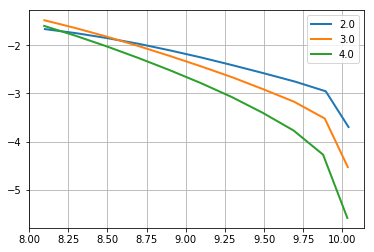

In [39]:

zplot = [2.0, 3.0, 4.0]
for iz , zz in enumerate(zplot):
    plt.plot(log10(mh1h1mfd[zz]), log10(nh1h1mfd[zz]/fach1mfbin),  lw=2, label=zz)
plt.legend()
plt.grid()

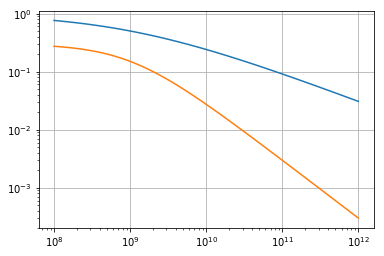

In [58]:
mstar = np.logspace(8, 12)
xx = np.log10(mstar)
mm = 1e9
aa = 0.0
bb = 0.5
mh1 = (((mstar/mm)**aa +(mstar/mm)**bb)**-1)

mm2 = 1e9
mh2 = 0.3*(mm2/(mstar + mm2))**1

plt.plot(mstar, mh1)
plt.plot(mstar, mh2)
plt.loglog()
plt.grid()

# bias

In [18]:

project = '/project/projectdirs/m3127/H1mass/'
bs, nc = 256, 256
# sim = '/lowres/%d-9100-fixed'%256
sim = '/highres/%d-9100-fixed'%2560
aafiles = np.array([0.1429, 0.1538, 0.1667, 0.1818, 0.2000, 0.2222, 0.2500, 0.2857, 0.3333])
zzfiles = np.array([round(tools.atoz(aa), 2) for aa in aafiles])

bias_int = []
bias_table = []
n = 6

for iz, zz in enumerate(zzfiles):
    aa = aafiles[iz]
    pkm = np.loadtxt(project + sim + '/fastpm_%0.4f/pkm.txt'%aa)[:, 1]
    pkhp = np.loadtxt(project + sim + '/fastpm_%0.4f/pkhpos.txt'%aa)[:, 1]
    pkhm = np.loadtxt(project + sim + '/fastpm_%0.4f/pkhmass.txt'%aa)[:, 1]
    pkhmx = np.loadtxt(project + sim + '/fastpm_%0.4f/pkhmassxm.txt'%aa)[:, 1]
    pkhpx = np.loadtxt(project + sim + '/fastpm_%0.4f/pkhposxm.txt'%aa)[:, 1]
    biases = [(pkhm[1:n]/pkm[1:n]).mean()**0.5, (pkhp[1:n]/pkm[1:n]).mean()**0.5, (pkhmx[1:n]/pkm[1:n]).mean(), (pkhpx[1:n]/pkm[1:n]).mean()]
    bias_int.append(biases)
    bias_table.append(np.loadtxt(project + sim + '/fastpm_%0.4f/halobias_bins.txt'%aa).T)
    
bias_int = np.array(bias_int)
bt = np.array(bias_table)

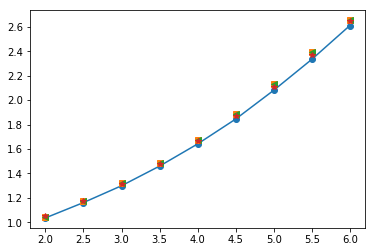

In [19]:
i = 1
def biashodfun(b, numwt, numx, denwt=None, denx=None):
    if denwt is None: denwt = numwt
    if denx is None: denx = numx
    return simps(b*numwt, numx) / simps(denwt, denx)

ib = 4


biashod = np.array([biashodfun(bt[j, ib], bt[j,2]/bt[j,0], bt[j, 0]) for j in range(zzfiles.size)])
biashod2 = np.array([biashodfun(bt[j, ib], bt[j, 2], np.log(bt[j, 0])) for j in range(zzfiles.size)])
biassum = np.array([(bt[j,ib]*bt[j,2]).sum()/(bt[j,2]).sum() for j in range(zzfiles.size)])


plt.plot(zzfiles, bias_int[:, i], marker='o')
plt.plot(zzfiles, biashod, 's')
plt.plot(zzfiles, biashod2, '<')
plt.plot(zzfiles, biassum, '*')


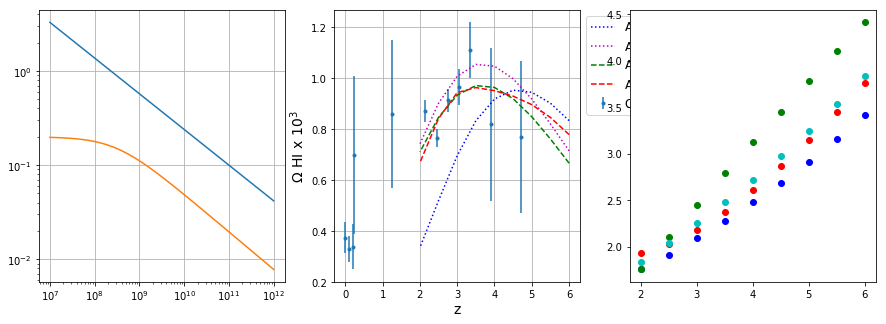

In [74]:

f = 0.03
alphasat = -0.8
plt.figure(figsize = (15, 5))

ax  = plt.subplot(1, 3, 1)

mstar = np.logspace(7, 12)
xx = np.log10(mstar)
mm = 1e9
aa = 0.0
bb = 0.5
mh1 = (((mstar/mm)**aa +(mstar/mm)**bb)**-1)
# plt.plot(mstar, mh1)

m, im = np.polyfit([8.1, 11], [0.1,  -1], deg=1)
plt.plot(10**xx, 10**(m*xx+im), label='linear fit')

# mmB = 5e7
# ffB = 0.35
# alphaB = .35
mmB = 3e8
ffB = 0.2
alphaB = .4
mh2 = ffB*(mmB/(mstar + mmB))**alphaB
plt.plot(mstar, mh2)

plt.loglog()
plt.grid()


def davequad(mhalo, zz, h=0.6776, scatter=None):
    mcut = mcutf(zz)
    mstar = moster(mhalo, zz, h=h, scatter=scatter)/h
    mm = mmB
    f = ffB
    alpha = alphaB
    mfrac = f*(mm/(mstar + mm))**alpha
    mh1 = mstar * mfrac
    return mh1*h 
#     return mh1*h * np.exp(-mcut/mhalo)

ax  = plt.subplot(1, 3, 2)

# #Get total HI
h1dave = np.zeros_like(zzfiles)
h1davequad = np.zeros_like(zzfiles)
h1davecen = np.zeros_like(zzfiles)
h1totplay = np.zeros_like(zzfiles)

for iz, zz in enumerate(zzfiles):
    aa = 1/(zz+1)
    mcut  = mcutf(zz)
    mmin = 1e9
    lnmh = np.log(np.logspace(np.log10(mmin), 15, 1000))
    num = mf.STf(np.exp(lnmh), aa) * bs**3

    mh1 = dave(np.exp(lnmh), zz, scatter=None)
    n = simps(num*mh1, lnmh)
    h1dave[iz] = n/bs**3 *(1+zz)**3

    mh1 = davequad(np.exp(lnmh), zz, scatter=None)
    n = simps(num*mh1, lnmh)
    h1davequad[iz] = n/bs**3 *(1+zz)**3

    numf = lambda m, mh: hodanals.nmsat(m, mh, f, alphasat)
    massf = lambda m: m
    msat = hodanals.massweightedsum(np.exp(lnmh), mcut/10., numf, massf)
    mh1 = davequad(np.exp(lnmh)-msat, zz)
    n = simps(num*mh1, lnmh)
    h1davecen[iz] = n/bs**3 *(1+zz)**3

    mcut, alpha, A = mcutf(zz), betaf(zz), normfplay(zz)
    mh1 = hodanals.HIm(np.exp(lnmh), mcut, alpha, A)
    n = simps(num*mh1, lnmh)
    h1totplay[iz] = n/bs**3 *(1+zz)**3    

plt.errorbar(omh1data[0], omh1data[1], omh1data[2], fmt='.', label='Observation')

plt.plot(zzfiles, h1dave/rhoCritCom(0)*1e3/10., 'b:',label='Analytic B Physical Old')
plt.plot(zzfiles, h1davequad/rhoCritCom(0)*1e3, 'm:',label='Analytic B Physical')
plt.plot(zzfiles, h1davecen/rhoCritCom(0)*1e3, 'g--',label='Analytic B Physical Cen')
plt.plot(zzfiles, h1totplay/rhoCritCom(0)*1e3, 'r--',label='Analytic A Physical')
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('z', fontsize=14)
plt.ylabel(r'$\Omega\ \rm{HI}\ x\ 10^3$', fontsize=14)
# plt.yscale('log')
plt.grid()

ax  = plt.subplot(1, 3, 3)

for iz, zz in enumerate(zzfiles):
    mm = bt[iz, 0]
    nn = bt[iz, 2]
    bb = bt[iz, -1]
    mcut, A, beta = mcutf(zz), normf(zz), betaf(zz)
    mh1 = hodanals.HIm(mm, mcut, beta, A)
    mh12 = davequad(mm, zz)
    mh1d = dave(mm, zz)
#     bh1 = np.array([(bb*n).sum()/(n).sum() for j in range(zzfiles.size)])
    bm = (bb*nn*mm).sum()/(mm*nn).sum()
    plt.plot(zz, bm, 'b', marker='o')
    bh1 = (bb*nn*mh1).sum()/(mh1*nn).sum()
    plt.plot(zz, bh1, 'r', marker='o')
    bh12 = (bb*nn*mh12).sum()/(mh12*nn).sum()
    plt.plot(zz, bh12, 'g', marker='o')
    bh1d = (bb*nn*mh1d).sum()/(mh1d*nn).sum()
    plt.plot(zz, bh1d, 'c', marker='o')


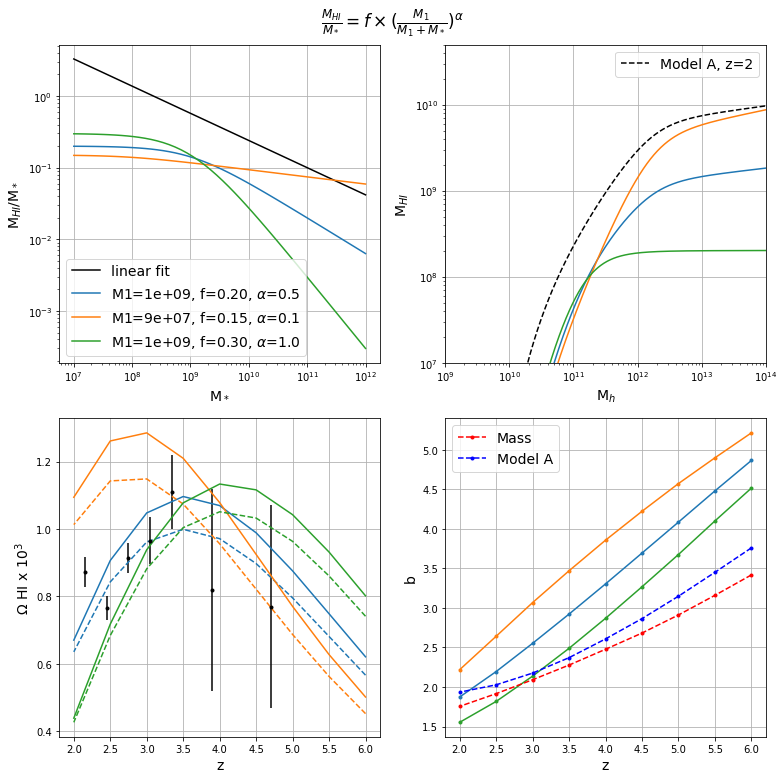

In [21]:

f = 0.03
alphasat = -0.8
fig, axar = plt.subplots(2, 2, figsize = (11, 11))

fsize = 14

ax = axar[0]
mstar = np.logspace(7, 12)
xx = np.log10(mstar)
mm = 1e9
aa = 0.0
bb = 0.5
mh1 = (((mstar/mm)**aa +(mstar/mm)**bb)**-1)
# plt.plot(mstar, mh1)

m, im = np.polyfit([8.1, 11], [0.1,  -1], deg=1)
ax[0].plot(10**xx, 10**(m*xx+im), 'k', label='linear fit')

ic = -1
for mmB, ffB, alphaB in [[1e9, 0.2, 0.5], [9e7, 0.15, 0.1], [1e9, 0.3, 1]]:    
    ic +=1
    ax = axar[0]
    mh2 = ffB*(mmB/(mstar + mmB))**alphaB
    ax[0].plot(mstar, mh2, 'C%d'%ic, label=r'M1=%.0e, f=%0.2f, $\alpha$=%0.1f'%(mmB, ffB, alphaB))
    ax[0].loglog()
    ax[0].set_xlabel('M$_*$', fontsize=fsize)
    ax[0].set_ylabel('M$_{HI}$/M$_*$', fontsize=fsize)
    ax[0].legend(fontsize=fsize)
    
    def davequad(mhalo, zz, h=0.6776, scatter=None):
        mcut = mcutf(zz)
        mstar = moster(mhalo, zz, h=h, scatter=scatter)/h
        mm = mmB
        f = ffB
        alpha = alphaB
        mfrac = f*(mm/(mstar + mm))**alpha
        mh1 = mstar * mfrac
        return mh1*h * np.exp(-mcut/mhalo)

    h1dave = np.zeros_like(zzfiles)
    h1davequad = np.zeros_like(zzfiles)
    h1davecen = np.zeros_like(zzfiles)

    ax = axar.flatten()[1:]
    for iz, zz in enumerate(zzfiles):
        aa = 1/(zz+1)
        mcut  = mcutf(zz)
        mmin = 1e9
        lnmh = np.log(np.logspace(np.log10(mmin), 15, 1000))
        num = mf.STf(np.exp(lnmh), aa) * bs**3

        mh1 = dave(np.exp(lnmh), zz, scatter=None)
        if zz == 2 and ic==1:
            axar[0, 1].plot(np.exp(lnmh), mh1, 'k--', label='Model A, z=2')
            axar[0, 1].legend(fontsize=fsize)
        n = simps(num*mh1, lnmh)
        h1dave[iz] = n/bs**3 *(1+zz)**3

        mh1 = davequad(np.exp(lnmh), zz, scatter=None)
        if zz == 2:
            axar[0, 1].plot(np.exp(lnmh), mh1, 'C%d-'%ic)
            axar[0, 1].loglog()
            axar[0, 1].set_ylim(1e7, 5e10)
            axar[0, 1].set_xlim(1e9, 1e14)
            axar[0, 1].set_xlabel('M$_h$', fontsize=fsize)
            axar[0, 1].set_ylabel('M$_{HI}$', fontsize=fsize)
        n = simps(num*mh1, lnmh)
        h1davequad[iz] = n/bs**3 *(1+zz)**3

        numf = lambda m, mh: hodanals.nmsat(m, mh, f, alphasat)
        massf = lambda m: m
        msat = hodanals.massweightedsum(np.exp(lnmh), mcut/10., numf, massf)
        mh1 = davequad(np.exp(lnmh)-msat, zz)
        n = simps(num*mh1, lnmh)
        h1davecen[iz] = n/bs**3 *(1+zz)**3

    ax[1].plot(zzfiles, h1davequad/rhoCritCom(0)*1e3,  'C%d'%ic)
    ax[1].plot(zzfiles, h1davecen/rhoCritCom(0)*1e3, 'C%d--'%ic)
    ax[1].set_xlabel('z', fontsize=fsize)
    ax[1].set_ylabel(r'$\Omega\ \rm{HI}\ x\ 10^3$', fontsize=fsize)


    bh1B = []
    for iz, zz in enumerate(zzfiles):
        mm = bt[iz, 0]
        nn = bt[iz, 2]
        bb = bt[iz, -1]
        mh12 = davequad(mm, zz)
        bh1B.append((bb*nn*mh12).sum()/(mh12*nn).sum())
    ax[2].plot(zzfiles, bh1B, 'C%d'%ic, marker='.')
    ax[2].set_ylabel('b', fontsize=fsize)
    ax[2].set_xlabel('z', fontsize=fsize)
    

ax[1].errorbar(omh1data[0][5:], omh1data[1][5:], omh1data[2][5:], color='k', fmt='.', label='Observation')
bm , bh1 = [], []
for iz, zz in enumerate(zzfiles):
    mm = bt[iz, 0]
    nn = bt[iz, 2]
    bb = bt[iz, -1]
    mcut, A, beta = mcutf(zz), normf(zz), betaf(zz)
    mh1 = hodanals.HIm(mm, mcut, beta, A)
    bm.append((bb*nn*mm).sum()/(mm*nn).sum())
    bh1.append((bb*nn*mh1).sum()/(mh1*nn).sum())
ax[2].plot(zzfiles, bm, 'r--', marker='.', label='Mass')
ax[2].plot(zzfiles, bh1, 'b--', marker='.', label='Model A')
ax[2].legend(fontsize=fsize)

for axis in axar.flatten(): axis.grid()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle(r'$\frac{M_{HI}}{M_*} = f \times (\frac{M_1}{M_1 + M_*})^\alpha$', fontsize=fsize+3)
plt.show()

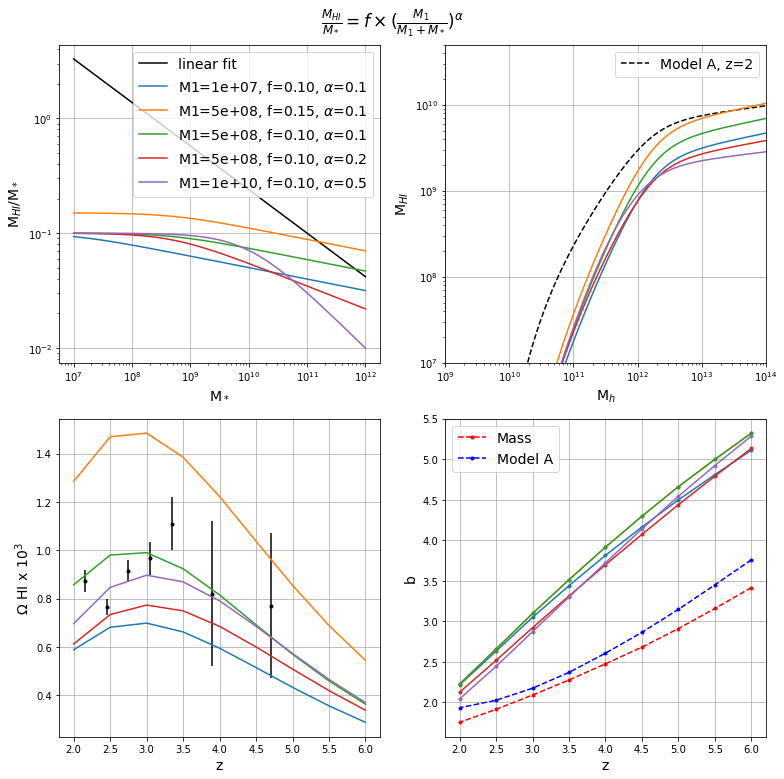

In [31]:
fig, axar = plt.subplots(2, 2, figsize = (11, 11))

fsize = 14

ax = axar[0]
mstar = np.logspace(7, 12)
xx = np.log10(mstar)
mm = 1e9
aa = 0.0
bb = 0.5
mh1 = (((mstar/mm)**aa +(mstar/mm)**bb)**-1)
# plt.plot(mstar, mh1)

m, im = np.polyfit([8.1, 11], [0.1,  -1], deg=1)
ax[0].plot(10**xx, 10**(m*xx+im), 'k', label='linear fit')

ic = -1
for mmB, ffB, alphaB in [[1e7, .1, 0.1], [5e8, 0.15, 0.1], [5e8, 0.1, 0.1], [5e8, 0.1, 0.2], [1e10, 0.1, 0.5]]:    
    ic +=1
    ax = axar[0]
    mh2 = ffB*(mmB/(mstar + mmB))**alphaB
    ax[0].plot(mstar, mh2, 'C%d'%ic, label=r'M1=%.0e, f=%0.2f, $\alpha$=%0.1f'%(mmB, ffB, alphaB))
    ax[0].loglog()
    ax[0].set_xlabel('M$_*$', fontsize=fsize)
    ax[0].set_ylabel('M$_{HI}$/M$_*$', fontsize=fsize)
    ax[0].legend(fontsize=fsize)
    
    def davequad(mhalo, zz, h=0.6776, scatter=None):
        mcut = mcutf(zz)
        mstar = moster(mhalo, zz, h=h, scatter=scatter)/h
        mm = mmB
        f = ffB
        alpha = alphaB
        mfrac = f*(mm/(mstar + mm))**alpha
        mh1 = mstar * mfrac
        return mh1*h * np.exp(-mcut/mhalo)

    h1dave = np.zeros_like(zzfiles)
    h1davequad = np.zeros_like(zzfiles)
    h1davecen = np.zeros_like(zzfiles)

    ax = axar.flatten()[1:]
    for iz, zz in enumerate(zzfiles):
        aa = 1/(zz+1)
        mcut  = mcutf(zz)
        mmin = 1e9
        lnmh = np.log(np.logspace(np.log10(mmin), 15, 1000))
        num = mf.STf(np.exp(lnmh), aa) * bs**3

        mh1 = dave(np.exp(lnmh), zz, scatter=None)
        if zz == 2 and ic==1:
            axar[0, 1].plot(np.exp(lnmh), mh1, 'k--', label='Model A, z=2')
            axar[0, 1].legend(fontsize=fsize)
        n = simps(num*mh1, lnmh)
        h1dave[iz] = n/bs**3 *(1+zz)**3

        mh1 = davequad(np.exp(lnmh), zz, scatter=None)
        if zz == 2:
            axar[0, 1].plot(np.exp(lnmh), mh1, 'C%d-'%ic)
            axar[0, 1].loglog()
            axar[0, 1].set_ylim(1e7, 5e10)
            axar[0, 1].set_xlim(1e9, 1e14)
            axar[0, 1].set_xlabel('M$_h$', fontsize=fsize)
            axar[0, 1].set_ylabel('M$_{HI}$', fontsize=fsize)
        n = simps(num*mh1, lnmh)
        h1davequad[iz] = n/bs**3 *(1+zz)**3

#         numf = lambda m, mh: hodanals.nmsat(m, mh, f, alphasat)
#         massf = lambda m: m
#         msat = hodanals.massweightedsum(np.exp(lnmh), mcut/10., numf, massf)
#         mh1 = davequad(np.exp(lnmh)-msat, zz)
#         n = simps(num*mh1, lnmh)
#         h1davecen[iz] = n/bs**3 *(1+zz)**3

    ax[1].plot(zzfiles, h1davequad/rhoCritCom(0)*1e3,  'C%d'%ic)
#     ax[1].plot(zzfiles, h1davecen/rhoCritCom(0)*1e3, 'C%d--'%ic)
    ax[1].set_xlabel('z', fontsize=fsize)
    ax[1].set_ylabel(r'$\Omega\ \rm{HI}\ x\ 10^3$', fontsize=fsize)


    bh1B = []
    for iz, zz in enumerate(zzfiles):
        mm = bt[iz, 0]
        nn = bt[iz, 2]
        bb = bt[iz, -1]
        mh12 = davequad(mm, zz)
        bh1B.append((bb*nn*mh12).sum()/(mh12*nn).sum())
    ax[2].plot(zzfiles, bh1B, 'C%d'%ic, marker='.')
    ax[2].set_ylabel('b', fontsize=fsize)
    ax[2].set_xlabel('z', fontsize=fsize)
    

ax[1].errorbar(omh1data[0][5:], omh1data[1][5:], omh1data[2][5:], color='k', fmt='.', label='Observation')
bm , bh1 = [], []
for iz, zz in enumerate(zzfiles):
    mm = bt[iz, 0]
    nn = bt[iz, 2]
    bb = bt[iz, -1]
    mcut, A, beta = mcutf(zz), normf(zz), betaf(zz)
    mh1 = hodanals.HIm(mm, mcut, beta, A)
    bm.append((bb*nn*mm).sum()/(mm*nn).sum())
    bh1.append((bb*nn*mh1).sum()/(mh1*nn).sum())
ax[2].plot(zzfiles, bm, 'r--', marker='.', label='Mass')
ax[2].plot(zzfiles, bh1, 'b--', marker='.', label='Model A')
ax[2].legend(fontsize=fsize)

for axis in axar.flatten(): axis.grid()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle(r'$\frac{M_{HI}}{M_*} = f \times (\frac{M_1}{M_1 + M_*})^\alpha$', fontsize=fsize+3)
plt.show()

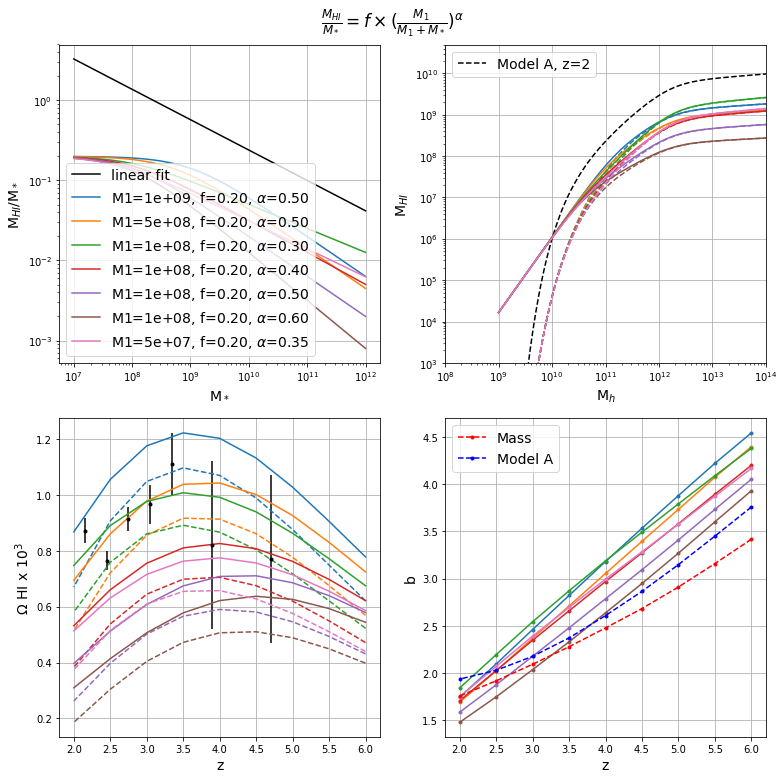

In [59]:
fig, axar = plt.subplots(2, 2, figsize = (11, 11))

fsize = 14

ax = axar[0]
mstar = np.logspace(7, 12)
xx = np.log10(mstar)
mm = 1e9
aa = 0.0
bb = 0.5
mh1 = (((mstar/mm)**aa +(mstar/mm)**bb)**-1)
# plt.plot(mstar, mh1)

m, im = np.polyfit([8.1, 11], [0.1,  -1], deg=1)
ax[0].plot(10**xx, 10**(m*xx+im), 'k', label='linear fit')

ic = -1
for mmB, ffB, alphaB in [[1e9, .2, 0.5], [5e8, .2, 0.5], [1e8, .2, 0.3], [1e8, .2, 0.4], [1e8, .2, 0.5], [1e8, .2, 0.6],  [5e7, .2, 0.35], ]:    
# for mmB, ffB, alphaB in [[1e8, .2, 0.4], [1e8, .2, 0.5], [1e8, .2, 0.6],  [5e7, .2, 0.35], ]:    
    ic +=1
    ax = axar[0]
    mh2 = ffB*(mmB/(mstar + mmB))**alphaB
    ax[0].plot(mstar, mh2, 'C%d'%ic, label=r'M1=%.0e, f=%0.2f, $\alpha$=%0.2f'%(mmB, ffB, alphaB))
    ax[0].loglog()
    ax[0].set_xlabel('M$_*$', fontsize=fsize)
    ax[0].set_ylabel('M$_{HI}$/M$_*$', fontsize=fsize)
    ax[0].legend(fontsize=fsize)
    
    def davequad(mhalo, zz, h=0.6776, scatter=None):
        mcut = mcutf(zz)
        mstar = moster(mhalo, zz, h=h, scatter=scatter)/h
        mm = mmB
        f = ffB
        alpha = alphaB
        mfrac = f*(mm/(mstar + mm))**alpha
        mh1 = mstar * mfrac
        return mh1*h 
#         return mh1*h * np.exp(-mcut/mhalo)

    h1dave = np.zeros_like(zzfiles)
    h1davequad = np.zeros_like(zzfiles)
    h1davequadcut = np.zeros_like(zzfiles)
    h1davecen = np.zeros_like(zzfiles)

    ax = axar.flatten()[1:]
    for iz, zz in enumerate(zzfiles):
        aa = 1/(zz+1)
        mcut  = mcutf(zz)
        mmin = 1e9
        lnmh = np.log(np.logspace(np.log10(mmin), 15, 1000))
        num = mf.STf(np.exp(lnmh), aa) * bs**3

        mh1 = dave(np.exp(lnmh), zz, scatter=None)
        if zz == 2 and ic==1:
            axar[0, 1].plot(np.exp(lnmh), mh1, 'k--', label='Model A, z=2')
            axar[0, 1].legend(fontsize=fsize)
        n = simps(num*mh1, lnmh)
        h1dave[iz] = n/bs**3 *(1+zz)**3

        mh1 = davequad(np.exp(lnmh), zz, scatter=None)
        mh1cut = mh1 *np.exp(-mcut/np.exp(lnmh))
        if zz == 2:
            axar[0, 1].plot(np.exp(lnmh), mh1, 'C%d-'%ic)
            axar[0, 1].plot(np.exp(lnmh), mh1cut, 'C%d--'%ic)
            axar[0, 1].loglog()
            axar[0, 1].set_ylim(1e3, 5e10)
            axar[0, 1].set_xlim(1e8, 1e14)
            axar[0, 1].set_xlabel('M$_h$', fontsize=fsize)
            axar[0, 1].set_ylabel('M$_{HI}$', fontsize=fsize)
        n = simps(num*mh1, lnmh)
        h1davequad[iz] = n/bs**3 *(1+zz)**3
        n = simps(num*mh1cut, lnmh)
        h1davequadcut[iz] = n/bs**3 *(1+zz)**3

#         numf = lambda m, mh: hodanals.nmsat(m, mh, f, alphasat)
#         massf = lambda m: m
#         msat = hodanals.massweightedsum(np.exp(lnmh), mcut/10., numf, massf)
#         mh1 = davequad(np.exp(lnmh)-msat, zz)
#         n = simps(num*mh1, lnmh)
#         h1davecen[iz] = n/bs**3 *(1+zz)**3

    ax[1].plot(zzfiles, h1davequad/rhoCritCom(0)*1e3,  'C%d'%ic)
    ax[1].plot(zzfiles, h1davequadcut/rhoCritCom(0)*1e3,  'C%d--'%ic)
#     ax[1].plot(zzfiles, h1davecen/rhoCritCom(0)*1e3, 'C%d--'%ic)
    ax[1].set_xlabel('z', fontsize=fsize)
    ax[1].set_ylabel(r'$\Omega\ \rm{HI}\ x\ 10^3$', fontsize=fsize)


    bh1B, bh1Bcut = [], []
    for iz, zz in enumerate(zzfiles):
        mcut = mcutf(zz)
        mm = bt[iz, 0]
        nn = bt[iz, 2]
        bb = bt[iz, -1]
        mh12 = davequad(mm, zz)
        bh1B.append((bb*nn*mh12).sum()/(mh12*nn).sum())
        mh12 = davequad(mm, zz)*np.exp(-mcut/mm)
        bh1Bcut.append((bb*nn*mh12).sum()/(mh12*nn).sum())
    ax[2].plot(zzfiles, bh1B, 'C%d'%ic, marker='.')
#     ax[2].plot(zzfiles, bh1Bcut, 'C%d--'%ic, marker='.')
    ax[2].set_ylabel('b', fontsize=fsize)
    ax[2].set_xlabel('z', fontsize=fsize)
    

ax[1].errorbar(omh1data[0][5:], omh1data[1][5:], omh1data[2][5:], color='k', fmt='.', label='Observation')
bm , bh1 = [], []
for iz, zz in enumerate(zzfiles):
    mm = bt[iz, 0]
    nn = bt[iz, 2]
    bb = bt[iz, -1]
    mcut, A, beta = mcutf(zz), normf(zz), betaf(zz)
    mh1 = hodanals.HIm(mm, mcut, beta, A)
    bm.append((bb*nn*mm).sum()/(mm*nn).sum())
    bh1.append((bb*nn*mh1).sum()/(mh1*nn).sum())
ax[2].plot(zzfiles, bm, 'r--', marker='.', label='Mass')
ax[2].plot(zzfiles, bh1, 'b--', marker='.', label='Model A')
ax[2].legend(fontsize=fsize)

for axis in axar.flatten(): axis.grid()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle(r'$\frac{M_{HI}}{M_*} = f \times (\frac{M_1}{M_1 + M_*})^\alpha$', fontsize=fsize+3)
plt.show()

 #### mmB, ffB, alphaB = [5e7, .f, 0.35]
 if remove mcut = 1e8, 0.2, 0.3 or 5e8, 0.2, 0.5
 or mmB = 3e8
ffB = 0.2
alphaB = .4

# Model C

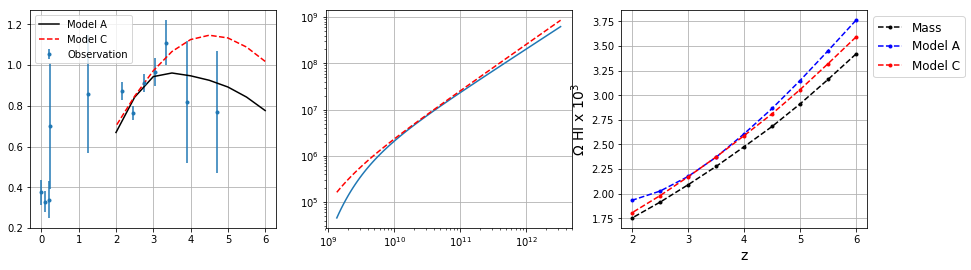

In [139]:
# normfplay = lambda zz : 3e7 *(4+(3.5/zz)**6) #without (1+z)**3
# normfplay = lambda zz : 1e6 *(4+(3.5/zz)**6)
mcutfplay = lambda zz : 1e9 + zz*0
betafplay = lambda zz: 1 + zz*0
# normfplay = lambda zz : 2e5*(1+4/zz**2)
normfplay = lambda zz : 2.2e5*(1+1/zz**1)

normfAnew = lambda zz : normf(zz)*3

#Get total HI
plt.figure(figsize = (15, 4))


# ax = plt.subplot(1, 3, 1)
# plt.plot(zzfiles, mcutfold(zzfiles), marker='o', label='Old Mcut')
# plt.plot(zzfiles, mcutf(zzfiles), marker='o', label='New Mcut')
# # plt.plot(zzfiles, normfone(zzfiles), marker='s')
# plt.legend()
# plt.grid()
# plt.xlabel('z', fontsize=14)
# plt.ylabel('Mcut', fontsize=14)

# ############

# ax = plt.subplot(1, 3, 2)

# xz = np.linspace(2, 6)
# plt.plot(zzfiles, normf(zzfiles), marker='o', label='Old Norm')
# plt.plot(zzfiles, normfplay(zzfiles), marker='o', label='New Norm')
# # plt.plot(zzfiles, normfone(zzfiles), marker='s')
# plt.semilogy()
# plt.legend()
# plt.grid()
# plt.xlabel('z', fontsize=14)
# plt.ylabel('Norm', fontsize=14)


#####

h1tot = np.zeros_like(zzfiles) 
h1totplay = np.zeros_like(zzfiles)
for iz, zz in enumerate(zzfiles):
    aa = 1/(zz+1)
    mmin = hmasscdfd[zz][-1]
    lnmh = np.log(np.logspace(np.log10(mmin), 15, 10000))
    num = mf.STf(np.exp(lnmh), aa) * bs**3
    
    mcut, alpha, A = mcutf(zz), betaf(zz), normfAnew(zz)
    mh1 = hodanals.HIm(np.exp(lnmh), mcut, alpha, A)
    n = simps(num*mh1, lnmh)
    h1tot[iz] = n/bs**3 *(1+zz)**3
    
    mcut, alpha, A = mcutfplay(zz), betafplay(zz), normfplay(zz)
    mh1 = hodanals.HIm(np.exp(lnmh), mcut, alpha, A)
    n = simps(num*mh1, lnmh)
    h1totplay[iz] = n/bs**3 *(1+zz)**3

ax = plt.subplot(1, 3, 1)
plt.errorbar(omh1data[0], omh1data[1], omh1data[2], fmt='.', label='Observation')
    
plt.plot(zzfiles, h1tot/rhoCritCom(0)*1e3, 'k',label='Model A')
plt.plot(zzfiles, h1totplay/rhoCritCom(0)*1e3, 'r--',label='Model C')
# plt.plot(zzfiles, h1dave/rhoCritCom(0)*1e3/10., 'm--',label='Analytic B/10')
plt.grid()
plt.legend()

ax = plt.subplot(1, 3, 2)

bm , bh1, bh1play = [], [], []
for iz, zz in enumerate(zzfiles):
    mm = bt[iz, 0]
    nn = bt[iz, 2]
    bb = bt[iz, -1]
    bm.append((bb*nn*mm).sum()/(mm*nn).sum())
    
    mcut, A, beta = mcutf(zz), normfAnew(zz), betaf(zz)
    mh1 = hodanals.HIm(mm, mcut, beta, A)
    bh1.append((bb*nn*mh1).sum()/(mh1*nn).sum())
    if not iz:plt.loglog(mm, mh1)
    
    mcut, alpha, A = mcutfplay(zz), betafplay(zz), normfplay(zz)
    mh1 = hodanals.HIm(mm, mcut, alpha, A)
    bh1play.append((bb*nn*mh1).sum()/(mh1*nn).sum())
    if not iz: plt.loglog(mm, mh1, 'r--')
plt.grid()
    

ax = plt.subplot(1, 3, 3)
plt.plot(zzfiles, bm, 'k--', marker='.', label='Mass')
plt.plot(zzfiles, bh1, 'b--', marker='.', label='Model A')
plt.plot(zzfiles, bh1play, 'r--', marker='.', label='Model C')
plt.legend(fontsize=fsize)


plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1,1))
plt.xlabel('z', fontsize=14)
plt.ylabel(r'$\Omega\ \rm{HI}\ x\ 10^3$', fontsize=14)
# plt.yscale('log')
plt.grid()
plt.show()

